In [160]:
import pandas as pd
import numpy as np
import os
from glob import glob
import re
from skimage import io

import torch
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch import nn
from torchvision import models

In [161]:
# Paths to directories with images
train_path = r'data/cnn_data/training_set/training_set'
test_path = r'data/cnn_data/test_set/test_set'

In [162]:
# Function to create a dataframe for
def annotations(train_path, variable=None):    
    list_name = []
    # Read each image 
    for file in glob(train_path + "\*.jpg"):
        try:
            # If the pattern is found store the image name in a list
            name_file = re.findall("(\w+\.\d+\.jpg)", file)[0]
            list_name.append(name_file)
            # The above syntax is used in case there are some trash files
            # in case it is not used 're.findall' returns a list with zero elements
            # and an exception is risen
        except IndexError:
            # Else print the error
            print('No organization match for {}'.format(file))
    # If true than hte index will be set to 1 for cat datframe
    if variable:       
        annotation_index = pd.Series(np.ones(len(list_name)), name='index', dtype='int64')
        file_name = pd.Series(list_name, name='file_name')
    # Else index will be set to 0
    else:
        annotation_index = pd.Series(np.zeros(len(list_name)), name='index', dtype='int64')
        file_name = pd.Series(list_name, name='file_name')
    return pd.concat([file_name, annotation_index], axis=1)

In [163]:
# Preparing the dataframe with annotations for train set
cat_df = annotations(os.path.join(train_path, 'cats'), variable=True)
dog_df = annotations(os.path.join(train_path, 'dogs'))
train_annotations = pd.concat([cat_df, dog_df], ignore_index=True)
# Shuffle the dataframe
train_annotations = train_annotations.sample(frac=1)
# Preparing the dataframe with annotations for test set
cat_df = annotations(os.path.join(test_path, 'cats'), variable=True)
dog_df = annotations(os.path.join(test_path, 'dogs'))
test_annotations = pd.concat([cat_df, dog_df], ignore_index=True)
# Shuffle the dataframe
test_annotations = test_annotations.sample(frac=1)

No organization match for data/cnn_data/training_set/training_set\dogs\dog.1642(1).jpg
No organization match for data/cnn_data/training_set/training_set\dogs\dog.3055(1).jpg
No organization match for data/cnn_data/training_set/training_set\dogs\dog.664(1).jpg
No organization match for data/cnn_data/training_set/training_set\dogs\dog.84(1).jpg
No organization match for data/cnn_data/training_set/training_set\dogs\dog.90(1).jpg
No organization match for data/cnn_data/test_set/test_set\cats\cat.4142(1).jpg
No organization match for data/cnn_data/test_set/test_set\cats\cat.4156(1).jpg
No organization match for data/cnn_data/test_set/test_set\cats\cat.4181(1).jpg
No organization match for data/cnn_data/test_set/test_set\cats\cat.4195(1).jpg
No organization match for data/cnn_data/test_set/test_set\cats\cat.4220(1).jpg
No organization match for data/cnn_data/test_set/test_set\cats\cat.4397(1).jpg
No organization match for data/cnn_data/test_set/test_set\cats\cat.4618(1).jpg
No organization m

In [164]:
train_annotations['index'].value_counts()

1    4000
0    4000
Name: index, dtype: int64

#### class DataSet

In [165]:
class CatDogsDataset(Dataset):
    def __init__(self, data, path , transform = None):
        # data - datframe with annotations
        # path - root directory for train and test set
        # transform - transforms used one images
        super().__init__()
        self.data = data
        self.path = path
        self.transform = transform
        
    def __len__(self):
        # Return the length of the dataframe
        return len(self.data)
    
    def __getitem__(self,index):
        # Given the path and the name of the image got from dataframe, read the image
        image = io.imread(os.path.join(self.path, self.data.iloc[index, 0]))
        # Transform the label to tensor
        y_label = torch.tensor(self.data.iloc[index, 1])
        # If transform is true, transform the image
        if self.transform:
            image = self.transform(image)
        # Returns a tuple the consist of the image and its label    
        return (image, y_label)

Transformers for images:

In [166]:
# Defining th mean and std for each channel from an image
means = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
# ToPILImage() - transforms the image into PILImage for future transformations
# CenterCrop(256) - crops the image from center, in this case we will have a crop of 256x256
# ToTensor() - transform to tensor
# Normalize(means,std) - normalize the calues
train_transform = transforms.Compose([#transforms.Resize(256),
                                      transforms.ToPILImage(),
                                      transforms.Resize((256, 256)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(means,std)])

test_transform = transforms.Compose([# transforms.Resize(256),
                                     transforms.ToPILImage(),
                                     transforms.Resize((256, 256)),  
                                     transforms.ToTensor(),
                                     transforms.Normalize(means,std)])

Transformers that i used in this project:

In [167]:
# ToPILImage() - transforms the image into PILImage for future transformations
# Resize((224, 224)) - resize image as 224x224
# RandomResizedCrop(224) - data augmentation where a crop of random size of the original size and a 
#                          random aspect ratio of the original aspect ratio is made.
# RandomHorizontalFlip() - flip horizontally the given image randomly with a given probability.
# ToTensor() - transform to tensor
train_transforms =  transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])

In [168]:
class Network(nn.Module):
    
    def __init__(self):
        super(Network,self).__init__()
        #  Pack multiple components into multilayer network.
        self.layer1 = nn.Sequential(
            # We have 3 RGB channels as input of convolutional layer
            # Kernel - size 3x3
            # Padding is used for extending the edge of an image if it is needed
            # MaxPool2D - applies a 2D max pooling over an input signal composed of several input plane
            # Stride - controls the stride for the cross-correlation
            # Relu - activation function
            # BtachNorm2D - Normalization id the tensor
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2))
        # We calculate the input for the linear function by multiplying the output and size of kernel user
        # and we obtain 3x3x64
        self.fc1 = nn.Linear(3*3*64, 50)
        # randomly zeroes some of the elements of the input tensor with 
        # probability p using samples from a Bernoulli distribution.
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(50,2)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        # Reshape into a 1D vector for giving the output of convolutional neural network to the linear function
        out = out.view(out.size(0),-1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

#### Initialize the model

In [169]:
# Initialize th model instance
model = Network()

In [170]:
# Define the loss function, here we use Cross Entropy Loss and optimizer Adam
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(params = model.parameters(),lr=0.001)

#### Calling DataSet and DataLoader classes:

In [171]:
train_set = CatDogsDataset(train_annotations, path=train_path, transform=train_transforms)
test_set = CatDogsDataset(test_annotations, path=test_path, transform=test_transforms)

train_loader = DataLoader(train_set, batch_size=50, shuffle=True)
test_loader = DataLoader(test_set, batch_size=50, shuffle=True)

#### Training Loop

In [172]:
EPOCH = 10

In [173]:
%%time

train_acc = torch.zeros(EPOCH)
train_loss = torch.zeros(EPOCH)
test_acc = torch.zeros(EPOCH)

for epoch in range(EPOCH):
    
    correct_train = 0
    total_train = 0
    loss_train = 0.0
    
    for samples, labels in train_loader:
        
        predictions = model(samples)
        
        loss = loss_func(predictions, labels)
        _, predicted = torch.max(predictions.data, 1)
        
        total_train += labels.size(0)
        # Count all the true positive predictions and sum them and add to the correct train
        correct_train += (predicted == labels).sum().item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss[epoch] = loss
    # Calculalte the accuracy
    train_acc[epoch] =  correct_train / total_train   
    # This loop computes the accuracy for test and train data
    correct = 0
    total = 0

    with torch.no_grad():
        for samples, labels in test_loader:
                
            # calculate outputs by running images through the network
            predictions = model(samples)
            loss_test = loss_func(predictions, labels)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(predictions, dim=1)
                    
            total += labels.shape[0]
            correct += int((predicted == labels).sum())
            # correct += ((predictions.argmax(dim=1) == labels).float().mean())
            
        test_acc[epoch] = correct / total
    print(f'''epoch {epoch}
            Train set - loss: {train_loss[epoch]}, accuracy: {train_acc[epoch]}
            Test set - loss: nothing to show, accuracy: {test_acc[epoch]}''')

epoch 0
            Train set - loss: 0.6451532244682312, accuracy: 0.6311249732971191
            Test set - loss: nothing to show, accuracy: 0.6340000033378601
epoch 1
            Train set - loss: 0.7003822326660156, accuracy: 0.6632500290870667
            Test set - loss: nothing to show, accuracy: 0.6499999761581421
epoch 2
            Train set - loss: 0.6763384342193604, accuracy: 0.6848750114440918
            Test set - loss: nothing to show, accuracy: 0.7020000219345093
epoch 3
            Train set - loss: 0.559609591960907, accuracy: 0.7036250233650208
            Test set - loss: nothing to show, accuracy: 0.7139999866485596
epoch 4
            Train set - loss: 0.5423957109451294, accuracy: 0.7137500047683716
            Test set - loss: nothing to show, accuracy: 0.7235000133514404
epoch 5
            Train set - loss: 0.4625723958015442, accuracy: 0.7264999747276306
            Test set - loss: nothing to show, accuracy: 0.7289999723434448
epoch 6
            Train set

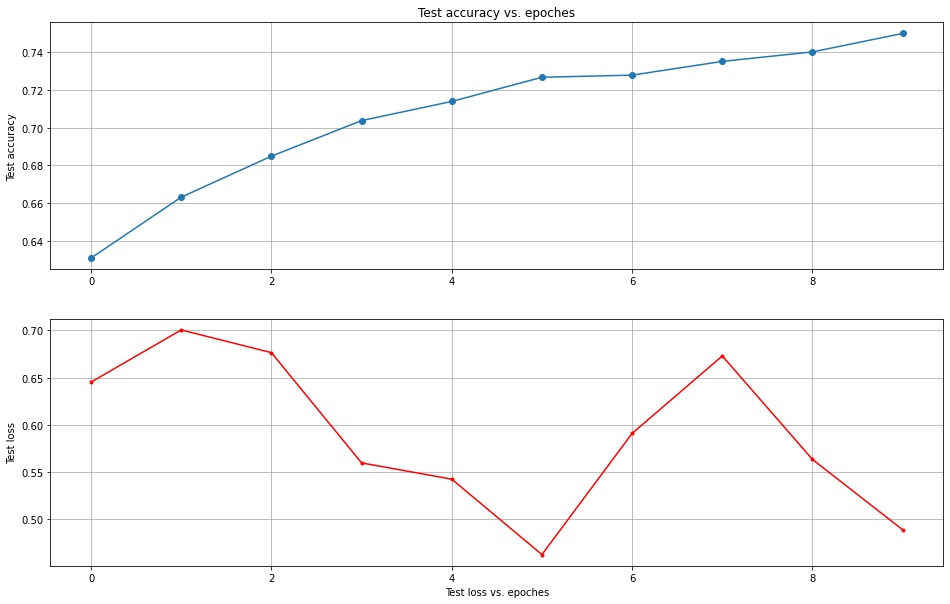

In [177]:
# Iterate and obtain points for 1000 values of x
import matplotlib.pyplot as plt

x1 = range(0, 10)
x2 = range(0, 10)
plt.figure(figsize=(16,10))
plt.subplot(2, 1, 1)
plt.plot(x1, train_acc.detach().numpy(), 'o-')
plt.title('Train accuracy vs. epoches')
plt.ylabel('Test accuracy')
plt.grid()
plt.subplot(2, 1, 2)
plt.plot(x2, train_loss.detach().numpy(), '.-', c='red')
plt.xlabel('Train loss vs. epoches')
plt.ylabel('Train loss')
plt.grid()
plt.show()

In [ ]:
_, max_index = torch.max(test_accuracy, dim=0)
max_index
# I can train the mmodel using the max_index, but it will 

#### ResNet18

In [178]:
resnet = models.resnet18(pretrained=True)

In [179]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(params = resnet.parameters(),lr=0.001)

In [182]:
%%time

train_acc = torch.zeros(EPOCH)
train_loss = torch.zeros(EPOCH)
test_acc = torch.zeros(EPOCH)
EPOCH = 5

for epoch in range(EPOCH):
    
    correct_train = 0
    total_train = 0
    loss_train = 0.0
    
    for samples, labels in train_loader:
        
        predictions = resnet(samples)
        
        loss = loss_func(predictions, labels)
        _, predicted = torch.max(predictions.data, 1)
        
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss[epoch] = loss
    train_acc[epoch] =  correct_train / total_train   
    # This loop computes the accuracy for test and train data
    correct = 0
    total = 0

    with torch.no_grad():
        for samples, labels in test_loader:
                
            # calculate outputs by running images through the network
            predictions = resnet(samples)
            loss_test = loss_func(predictions, labels)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(predictions, dim=1)
                    
            total += labels.shape[0]
            correct += int((predicted == labels).sum())
            
        test_acc[epoch] = correct / total
    print(f'''epoch {epoch}
            Train set - loss: {train_loss[epoch]}, accuracy: {train_acc[epoch]}
            Test set - loss: nothing to show, accuracy: {test_acc[epoch]}''')

epoch 0
            Train set - loss: 0.31597983837127686, accuracy: 0.9073749780654907
            Test set - loss: nothing to show, accuracy: 0.9045000076293945
epoch 1
            Train set - loss: 0.22670568525791168, accuracy: 0.9111250042915344
            Test set - loss: nothing to show, accuracy: 0.9229999780654907
epoch 2
            Train set - loss: 0.13218016922473907, accuracy: 0.9150000214576721
            Test set - loss: nothing to show, accuracy: 0.9125000238418579
epoch 3
            Train set - loss: 0.30624592304229736, accuracy: 0.9176250100135803
            Test set - loss: nothing to show, accuracy: 0.9075000286102295
epoch 4
            Train set - loss: 0.16661107540130615, accuracy: 0.9151250123977661
            Test set - loss: nothing to show, accuracy: 0.9110000133514404
Wall time: 1h 23min 33s


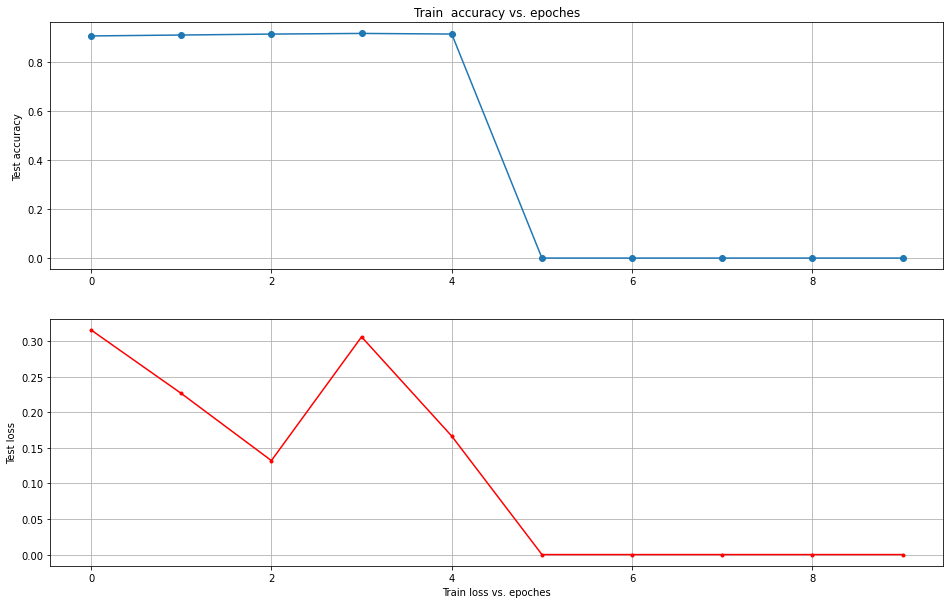

In [186]:
# Iterate and obtain points for 1000 values of x
import matplotlib.pyplot as plt

x1 = range(0, 10)
x2 = range(0, 10)
plt.figure(figsize=(16,10))
plt.subplot(2, 1, 1)
plt.plot(x1, train_acc.detach().numpy(), 'o-')
plt.title('Train  accuracy vs. epoches')
plt.ylabel('Test accuracy')
plt.grid()
plt.subplot(2, 1, 2)
plt.plot(x2, train_loss.detach().numpy(), '.-', c='red')
plt.xlabel('Train loss vs. epoches')
plt.ylabel('Test loss')
plt.grid()
plt.show()